# 1. Review: Q_Learning

In this notebook we will apply Q_Learning to design a trading policy for the stock in Chinese market.

We briefly review the algorithm for SARSA:

Set $\epsilon = 1, k = 1$, Initialize $\epsilon$-Greedy policy $\pi_k$; 

$\pi_k = \epsilon-Greedy(Q)$;

Take $a_k\sim \pi_k(s_k)$, Observe $(r_k, s_{k+1})$.

**Begin Loop**

Take $a_{k+1}\sim \pi_k(s_{k+1})$, Observe $(r_{k+1}, s_{k+2})$.

Let $Q(s_k, a_k) = Q(s_k, a_k) + \alpha_k(r_k + \gamma \max_{a'} Q(s_{k+1}, a') - Q(s_k, a_k)) $

$k = k + 1$, $\epsilon = 1/k$, $\pi_k = \epsilon-Greedy(Q)$

**End Loop**

# 2. Implementation

## 2.1 Load Data

In [1]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from single_stock_pi import SingleStockPI

In [2]:
pro = tushare.pro_api()
ts_code_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code')['ts_code'][:100]

def download_data(ts_code_list):
    for ts_code in ts_code_list:
        start_date = '20100101'
        end_date = '20200101'
        df = tushare.pro_bar(ts_code=ts_code, adj='qfq', start_date=start_date, end_date=end_date)
        df.to_csv('./data/' + ts_code, mode = 'w')
    print("done")
    
def load_data(ts_code):
    filepath = './data/' + ts_code
    df = pd.read_csv(filepath)
    return df

In [3]:
# load data and reverse the time series
ts_code = '000036.SZ'
df = load_data(ts_code)
df = df.set_index(df.index[::-1]).sort_index()

## 2.2 Data Preprocess

We need to design a discretization function that transforms the K-dimensional features into an interger that represents the current state $s$.

In [4]:
def compute_split_list(features, alphas_list):
    """
    Function that compute the split list for discretization
    
    Input:
    features: N * K numpy array, N obs, K features 
              NOTE: Here features should be data in the training set.
              
    alphas_list: [alphas[1], ..., alphas[K]]
              each alphas[i] is an array of spliting quantile for the i-th feature
    """
    if len(np.shape(features)) == 1:
        features = np.matrix(features).T
    else:
        features = np.matrix(features)
    assert features.shape[1] == len(alphas_list)
    N, K = features.shape
    splits_list = []
    for f_id in range(K):
        splits_list.append([-np.inf] + [np.quantile(features[:,f_id],alpha) for alpha in alphas_list[f_id]] 
                            + [np.inf])
    return splits_list
    
def discretize(features, splits_list):
    """
    Function that transforms the features matrix into discrete state
    
    Input:
    Features: N * K numpy array, N obs, K features
    split_list: [splits[1], ..., splits[K]]
            each splits[i] is an array of spliting position for the i-th feature
    """
    if len(np.shape(features)) == 1:
        features = np.matrix(features).T
    else:
        features = np.matrix(features)
    assert features.shape[1] == len(splits_list)
    N, K = features.shape
    num_group_list = np.array([len(splits) - 1 for splits in splits_list])
    discrete_features = np.zeros_like(features, dtype = np.int)
    for f_id in range(K):
        discrete_features[:,f_id] = np.digitize(features[:,f_id], splits_list[f_id]) - 1
    S = np.zeros(N)
    if K == 1:
        S = np.array(discrete_features[:,0]).squeeze()
    else:
        S = np.array(discrete_features @ np.insert(np.cumprod(num_group_list[:-1]),0,1)).squeeze()
    return S

Do discretization for stock data with multiple features

In [5]:
df['1_day_pct_chg'] = df['close'].pct_change(1)
df['5_day_pct_chg'] = df['close'].pct_change(5)
features = df[{"1_day_pct_chg", "5_day_pct_chg"}].to_numpy()[5:]
features.shape

(2373, 2)

Compute Split points for stock data:

In [6]:
training_set_size = 2000
features_train = features[:training_set_size,:]
alphas_list = [[0.25,0.5,0.75],[0.25,0.5,0.75]]
split_list = compute_split_list(features_train, alphas_list)
split_list

[[-inf, -0.03303390540602147, 0.0, 0.030604571891537535, inf],
 [-inf, -0.012894026149780025, 0.0, 0.012638792812033395, inf]]

compute state id:

In [7]:
S = discretize(features, split_list)[:-1]

visualize the distribution of S, make sure every state has enough data.

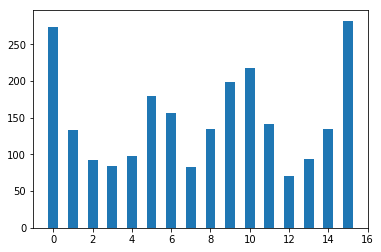

In [8]:
plt.hist(S, bins = np.arange(-0.5,16.5,1), rwidth = 0.5)
plt.show()

## 2.3 Implementation of Q-Learning

$S = \{0,1,...,15\}$, $A = \{0(\text{zero position}), 1(\text{full position})\}$

In [9]:
numS = 16
numA = 2
next_log_return = np.log(1+df['pct_chg'].shift(-1)/100)[5:-1].to_numpy()

def epsilon_greedy(s, epsilon, Q_SA):
    # helper function that computes the epsilon-greedy policy
    
    indicator = np.random.binomial(1, epsilon)
    a_argmax = np.argmax(Q_SA[s,:])
    a_rand = np.random.randint(numA)
    if indicator:
        a = a_rand
    else:
        a = a_argmax    
    return a
    
def Q_learning(S, next_log_return, gamma):
    # learn trading policy using Monte Carlo method
    
    Q_SA = np.zeros((numS, numA))
    
    epsilon, k, alpha = 1, 1, 1
    s_k = S[0]
    a_k = epsilon_greedy(s_k, epsilon, Q_SA)
    r_k = a_k * next_log_return[0]
    log_returns = np.array([r_k])
    
    while k < len(S):
        s_kp1 = S[k]
        a_kp1 = epsilon_greedy(s_kp1, epsilon, Q_SA)
        r_kp1 = a_kp1 * next_log_return[k]
        log_returns = np.append(log_returns,r_kp1)
        
        Q_SA[s_k, a_k] = (Q_SA[s_k, a_k] + alpha * 
                          (r_k + gamma*np.max(Q_SA[s_kp1, :]) - Q_SA[s_k, a_k]))
        
        k = k + 1
        alpha = 1/k
        epsilon = min(1, 1/(0.02*k))
        s_k, a_k, r_k = s_kp1, a_kp1, r_kp1
        
    return log_returns

In [10]:
policy_log_returns = Q_learning(S, next_log_return, gamma = 0.95)

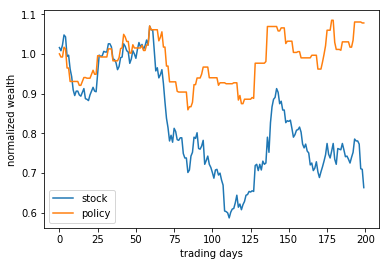

In [11]:
def plot1():
    plt.plot(np.exp(np.cumsum(next_log_return[:200])))
    plt.plot(np.exp(np.cumsum(policy_log_returns[:200])))
    plt.legend(["stock","policy"])
    plt.xlabel('trading days')
    plt.ylabel('normalized wealth')
    plt.show()
plot1()

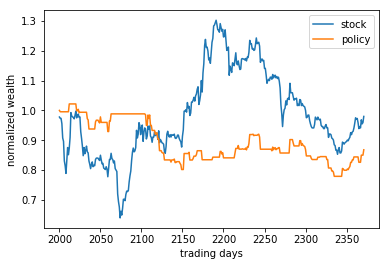

In [12]:
def plot2():
    days = range(training_set_size, training_set_size + len(policy_log_returns[training_set_size:]))
    plt.plot(days, np.exp(np.cumsum(next_log_return[training_set_size:])))
    plt.plot(days, np.exp(np.cumsum(policy_log_returns[training_set_size:])))
    plt.legend(["stock","policy"])
    plt.xlabel('trading days')
    plt.ylabel('normalized wealth')
    plt.show()
plot2()

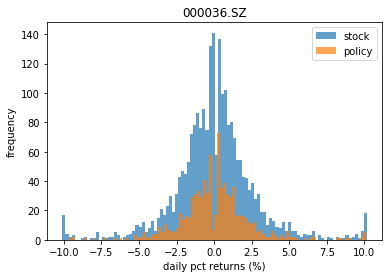

In [13]:
def plot3():
    plt.hist(100*(np.exp(next_log_return)-1), bins = 100, alpha = 0.7)
    plt.hist(100*(np.exp(policy_log_returns[policy_log_returns!=0])-1), bins = 100, alpha = 0.7)
    plt.legend(["stock","policy"])
    plt.xlabel('daily pct returns (%)')
    plt.ylabel('frequency')
    plt.title(ts_code)
    plt.show()
plot3()

# 3 Test the performance of SARSA on multiple stocks

In [14]:
stock_return_list = np.array([])
policy_return_list = np.array([])
for ts_code in ts_code_list:
    if ts_code == '000029.SZ':
        # 停牌
        continue
    df = load_data(ts_code)
    df = df.set_index(df.index[::-1]).sort_index()
    
    df['1_day_pct_chg'] = df['close'].pct_change(1)
    df['5_day_pct_chg'] = df['close'].pct_change(5)
    features = df[{"1_day_pct_chg", "5_day_pct_chg"}].to_numpy()[5:]
    
    training_set_size = len(df) - 200
    features_train = features[:training_set_size,:]
    alphas_list = [[0.25,0.5,0.75],[0.25,0.5,0.75]]
    split_list = compute_split_list(features_train, alphas_list)
    S = discretize(features, split_list)[:-1]
    
    numS = 16
    numA = 2
    
    next_log_return = np.log(1+df['pct_chg'].shift(-1)/100)[5:-1].to_numpy()
    policy_log_returns = Q_learning(S, next_log_return, gamma = 0.95)
    
    stock_return_test = np.exp(np.sum(next_log_return[training_set_size:]))
    policy_return_test = np.exp(np.sum(policy_log_returns[training_set_size:]))
    stock_return_list = np.append(stock_return_list,stock_return_test)
    policy_return_list = np.append(policy_return_list,policy_return_test)

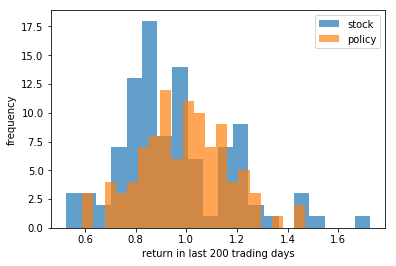

In [15]:
plt.hist(stock_return_list, bins = 20, alpha = 0.7)
plt.hist(policy_return_list, bins = 20, alpha = 0.7)
plt.legend(["stock","policy"])
plt.xlabel('return in last 200 trading days')
plt.ylabel('frequency')
plt.show()

## 3.1 Winning Rate

In [16]:
sum(np.array(stock_return_list) < np.array(policy_return_list))/len(stock_return_list)

0.6464646464646465

## 3.2 Mean Excess Return

In [17]:
np.mean(policy_return_list-stock_return_list)

0.040345508449659284